<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab ListricKinematicExtender component

*(Greg Tucker, University of Colorado Boulder, March 2021; revised June 2023 to use AdvectionSolverTVD instead of stepwise extension algorithm)*

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial demonstrates how to use the `ListricKinematicExtender` component. `ListricKinematicExtender` models the vertical subsidence and lateral tectonic motion associated with a listric detachment fault. A listric fault is one that shallows with depth, such that the fault plane has a concave-upward profile. The word "kinematic" indicates that this component does not calculate the mechanics of stress and strain involved in an extensional fault; it simply aims to mimic them geometrically. The basic concept is to solve the advection equation for a hangingwall block of thickness $H(x,y,t)$ moving at velocity $u(x,y,t)$ relative to an underlying footwall block, to is fixed relative to the grid. 

## Theory

### Describing a listric fault plane

Consider a fault plane with dip angle $\alpha$ relative to the horizontal. The fault plane has a listric shape, in which the dip angle at the surface is $\alpha_0$, and it becomes increasingly shallow with depth, ultimately asymptoting to horizontal at depth $h$ (we'll refer to $h$ as the detachment depth). We can express the dip angle in terms of gradient $G = \tan\alpha$, and $G_0 = \tan\alpha_0$. Let the gradient decay exponentially with distance from its zero-surface trace, $x_f$, starting from the surface value $G_0$:

$$G(x) = G_0 e^{-x_f/\lambda}$$

where $\lambda$ is a length scale that we'll define in a moment. "Zero-surface trace" here means the line of intersection of the fault plane with the horizontal plane at zero elevation (the actual surface trace would depend on the elevation field). Because $G$ is the rate of change of fault plane elevation, $z_f$, with distance $x$, we can write:

$$\frac{dz_f}{dx_f} = -G_0 e^{-x_f/\lambda}\hskip1em\mbox{(1)}$$

Integrating,

$$z_f(x) = G_0\lambda e^{-x_f/\lambda} + C$$

We can evaluate the constant of integration by noting that $z_f = 0$ at $x_f = 0$ (in other words, by definition the fault plane elevation is zero at the line where it intersects the zero-elevation horizontal plane), so

$$C = -G_0\lambda$$

Plugging this back in,

$$z_f(x_f) = -G_0\lambda (1 - e^{-x_f/\lambda})$$

Note that the fault elevation asymptotes to a detachment depth $h = G_0\lambda$. This gives us a physical basis for $\lambda$, and means we can express our fault plane geometry by $h$ instead of $\lambda$:

$$\boxed{z_f(x_f) = -h \left(1 - e^{-x_f G_0 / h}\right)}$$

Let's plot it:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

alpha0 = 60.0  # fault dip at surface, degrees
h = 10.0  # detachment depth, km

G0 = np.tan(np.deg2rad(alpha0))
x = np.arange(0, 41.0)
z = -h * (1.0 - np.exp(-x * G0 / h))

plt.plot(x, z, "k")
plt.xlabel("Distance (km)")
plt.ylabel("Fault plane elevation (km)")

If the topographic elevation is $z(x,y,t)$, then the hangingwall thickness is

$$H(x,y,t) = \max (z - z_f, 0)$$

### Rate of change of hangingwall thickness

Imagine that the hangingwall "block" is moving at velocity $\mathbf{u} = (u_x, u_y)$ relative to our coordinate system. This motion can be described by an advection (wave) equation,

$$\frac{\partial H}{\partial t} = -\left( u_x \frac{\partial H}{\partial x} + u_y \frac{\partial H}{\partial y}\right)$$

The topographic surface is the sum of the height of the footwall block, $z_{fw}$, and the thickness of the hangingwall $H$ (which might be zero), so the evolution equation for topographic elevation is

$$\frac{\partial z}{\partial t} = \frac{\partial z_{fw}}{\partial t} + \frac{\partial H}{\partial t}$$

or

$$\frac{\partial z}{\partial t} = \frac{\partial z_{fw}}{\partial t} -\left( u_x \frac{\partial H}{\partial x} + u_y \frac{\partial H}{\partial y}\right)$$

In principle, the height of the footwall surface could change through several mechanisms: isostatic uplift or subsidence, dynamic topography effects, and where the hangingwall is absent, erosion and sedimentation. From the point of view of the listrict kinematic extender component, these are considered external processes that are to be handled elsewhere.

The fault plane comes into the picture as an initial condition. The height of the footwall block starts out as the lesser of the fault plane or the initial topographic surface:

$$z_{fw}(x,y,0) = \min \left(z_f, z(x,y,0)\right)$$

For example, suppose $z(x,y,0) = 0$. Then

$$z_{fw} = \min \left[ -h \left(1 - e^{-x_f G_0 / h}\right), 0 \right]$$

## Implementation

The implementation in `ListricKinemticExtender` initializes fields for $z_f$ (`fault_plane__elevation`), $H$ (`hangingwall__thickness`), and  $\mathbf{u}$ (`advection__velocity`). The component then uses the `AdvectionSolverTVD` component to compute lateral motion and resulting changes in $H$.

### Initialization

#### Zero-surface fault trace

It's useful to represent the zero-surface fault trace as a parametric line. If the strike angle is $\alpha$ and the parameter is $t$, the equations are:

$$x_{ft} = x_0 + t \cos \alpha$$

$$y_{ft} = y_0 + t \sin \alpha$$

This is handy because it represents the trace in terms of an intercept point $(x_0, y_0)$ and a strike angle $\alpha$.

The closest distance of a point $(P_x, P_y)$ to the line is

$$d(P_x, P_y) = \sin\alpha (P_x-x_0) - \cos\alpha (P_y-y_0)$$

The below code uses a Landlab `RasterModelGrid` to illustrate this with three cases:

- Horizontal line: $x_0 = 0, y_0 = 0.5, \alpha = 0^\circ$
- Vertical line: $x_0 = 0.5, y_0 = 0, \alpha = 90^\circ$
- Diagonal line: $x_0 = y_0 = 0, \alpha = 45^\circ$

In [ ]:
def dist_to_line(Px, Py, x0, y0, alpha):
    alpha_r = np.radians(alpha)
    return np.sin(alpha_r) * (Px - x0) - np.cos(alpha_r) * (Py - y0)

In [ ]:
from landlab import RasterModelGrid, imshow_grid

grid = RasterModelGrid((101, 101), xy_spacing=0.01)

In [ ]:
d2l = dist_to_line(grid.x_of_node, grid.y_of_node, 0, 0.5, 0)
imshow_grid(grid, d2l)

In [ ]:
d2l = dist_to_line(grid.x_of_node, grid.y_of_node, 0.5, 0, 90)
imshow_grid(grid, d2l)

In [ ]:
d2l = dist_to_line(grid.x_of_node, grid.y_of_node, 0, 0, 45)
imshow_grid(grid, d2l)

#### Fault-plane surface and hangingwall thickness

Once we have distance-to-fault-trace, we can use that to calculate the fault plane elevation at each grid node, and from that, the thickness of the hangingwall. Here's a very simple example case:

- 3x3 raster grid with a node spacing of 1,000 m
- elevation is zero everywhere
- surface fault dip is 60 degrees
- detachment depth is 10 km
- fault is oriented north-south, intercepting (0, 0)

In this case, the center node (which is also the only core node) is located at $x=1,000$ m, $y=1,000 m$ relative to the origin. That puts it 1,000 m from the zero-elevation fault trace. Thus, the elevation of the footwall should be:

$$z_{fw} = \min \left[ -(10,000) \left(1 - e^{-(1,000) (\tan 60) / (10,000)}\right), 0 \right]$$

The hangingwall thickness is:

$$H = z_0 - z_{fw}$$

Here's the calculation:

In [ ]:
def calc_fw_and_hw(xf, h, G0, z0):
    zfw = np.minimum(-h * (1.0 - np.exp(-xf * np.tan(np.radians(G0)) / h)), z0)
    H = z0 - zfw
    return zfw, H

zfw, H = calc_fw_and_hw(1000.0, 10000.0, 60.0, 0.0)
print("Footwall elevation =", zfw)
print("Hangingwall thickness =", H)

Here's what the fault plane and hangingwall thickness look like in an example calculated using the default values in `ListricKinematicExtender`:

In [ ]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import ListricKinematicExtender

grid = RasterModelGrid((51, 51), xy_spacing=1000.0)
elev = grid.add_zeros("topographic__elevation", at="node")
extender = ListricKinematicExtender(grid)

imshow_grid(grid, grid.at_node["fault_plane__elevation"])
plt.figure()
imshow_grid(grid, grid.at_node["hangingwall__thickness"])

### Processing extension

To calculate changes in hangingwall thickness and surface elevation, the `ListricKinematicExtender` component relies on another, more general, component: `AdvectionSolverTVD`. The basic concept is to calculate changes in local hangingwall thickness resulting from its horizontal motion, and from that update the surface elevation.

`AdvectionSolverTVD` implements a numerical solution to the 2D advection equation using a second-order, nonlinear, Total Variation Diminishing (TVD) method. For more information, see the documentation and tutorial for that component.

The following are simple tests to verify that it is working properly. 

#### Simple test cases

Consider westward motion of a hangingwall relative to a north-south fault trace. After a time interval $T$ at a speed $u$, the hangingwall will have moved a distance $uT$ relative to the fixed footwall. This means that the thickness at a distance $x$ from the zero-surface fault trace will have changed from an original thickness $H(x)$ to a new thickness $H(x-uT)$. Suppose the starting elevation field (before any extensional movement) is $z_0$. From above, and assuming that both $x$ and $x-uT$ are locations where $H>0$, before motion the thickness is:

$$H_\text{before} = z_0 + h \left(1 - e^{-x G_0 / h}\right)$$

After motion (and assuming no independent changes in elevation) the thickness becomes:

$$H_\text{after} = z_0 + h \left(1 - e^{-(x-uT) G_0 / h}\right)$$

For a concrete example, consider a case in which $h=10,000$ m, $G_0=\tan 60^\circ$,  $x=1,000$ m, $u=0.001$ m/y, and $T=5\times 10^5$ y. Then the value of $H$ after motion should be:

In [ ]:
G0 = np.tan(np.radians(60.0))
print('G0', G0)
h = 10000.0
u = 0.001
T = 5.0e5
z0 = 0.0
x = 1000.0
H_before = z0 + h * (1.0 - np.exp(-G0 * x / h))
H_before500 = z0 + h * (1.0 - np.exp(-G0 * 500.0 / h))
H_after = z0 + h * (1.0 - np.exp(-G0 * (x - u * T) / h))
print("Thickness at x = 1000 m before motion =", H_before)
print("Thickness at x = 1000 m before motion =", H_before500)
print("Thickness at x = 1000 m after 500 years of motion at 0.001 m/y =", H_after)

The following code tests this using a simple Landlab grid:

In [ ]:
dx = 10.0  # node spacing, m
fault_x0 = 100.0
grid = RasterModelGrid((3, 130), xy_spacing=dx)
elev = grid.add_zeros("topographic__elevation", at="node")
extender = ListricKinematicExtender(grid, fault_x0=fault_x0, fault_strike=90.0)

# Verify that node 240 is at xf=1000 and node 190 is at xf=500
print("Node 240 xf =", grid.x_of_node[240] - fault_x0)
print("Node 190 xf =", grid.x_of_node[190] - fault_x0)

H = grid.at_node["hangingwall__thickness"]
print("Initial thickness at xf = 1000 m:", H[240])
print("Initial thickness at xf = 500 m:", H[190])

dt = 0.2 * dx / u  # time-step duration, y
nsteps = int(500000.0 / dt)
print(nsteps)
for _ in range(nsteps):
    extender.run_one_step(dt)
print("After extension, thickness at xf = 1000 m (node 240) is", H[240])

The component will also automatically update elevation as the sum of fault-plane elevation and hangingwall thickness. In the above example, at $x_f = 1000$ m, elevation should decline by the difference between the old and new hangingwall thickness, which is approximately 1590 - 830 = 760 m. Because it starts from zero elevation, the new elevation should be about -760 m:

In [ ]:
print("New elevation at xf = 1000 m is", elev[240])

The plot below shows a profile of the hangingwall and topography after 500 ky of extension (the "spike" in elevation on the right is just the initial condition, which does not change on the boundary nodes unless we force it to):

In [ ]:
midrow = np.arange(130, 260, dtype=int)
xmid = grid.x_of_node[midrow]
plt.plot(xmid, grid.at_node["fault_plane__elevation"][midrow], 'r', label='Fault plane')
plt.plot(xmid, elev[midrow], 'k', label='Surface')
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.legend()

## Examples

### Example 1: Quasi-1D

The first example uses a quasi-1D setup to represent an initially level topography on which subsidence progressively accumulates. 

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from landlab import RasterModelGrid, imshow_grid
from landlab.components import ListricKinematicExtender

In [23]:
# parameters
nrows = 3
ncols = 51
dx = 1000.0  # grid spacing, m
nsteps = 20  # number of iterations
dt = 2.5e5  # time step, y
extension_rate = 0.001  # m/y
detachment_depth = 10000.0  # m
fault_dip = 60.0  # fault dip angle, degrees
fault_x0 = 10000.0  # m from left side of model

In [27]:
# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros("topographic__elevation", at="node")

# Instantiate component
extender = ListricKinematicExtender(
    grid,
    extension_rate_x=extension_rate,
    extension_rate_y=0.0,
    fault_dip=fault_dip,
    fault_x0=fault_x0,
    fault_y0=0.0,
    fault_strike=90.0,
    detachment_depth=detachment_depth,
)

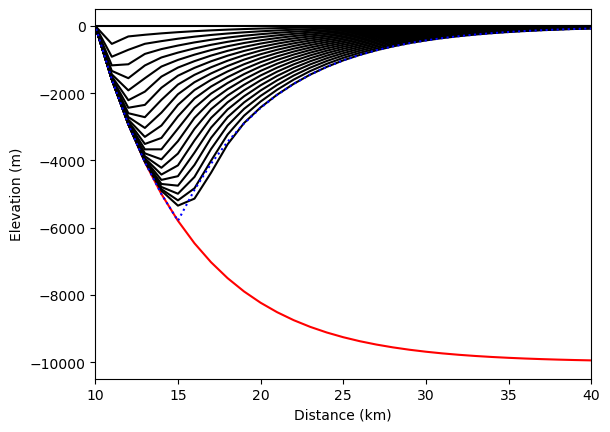

In [28]:
# Plot the starting elevations, in cross-section (middle row)
midrow = np.arange(ncols, 2 * ncols, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], "k")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.xlim([10.0, 40.0])

# Add a plot of the fault plane
dist_from_fault = grid.x_of_node - fault_x0
dist_from_fault[dist_from_fault < 0.0] = 0.0
x0 = detachment_depth / np.tan(np.deg2rad(fault_dip))
fault_plane = -(detachment_depth * (1.0 - np.exp(-dist_from_fault / x0)))
plt.plot(grid.x_of_node[midrow] / 1000.0, fault_plane[midrow], "r")

for i in range(nsteps):
    extender.run_one_step(dt)
    plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], "k")

# Add the analytic solution
total_time = nsteps * dt
G0 = np.tan(np.deg2rad(fault_dip))
shifted_dist_from_fault = np.maximum(dist_from_fault - extension_rate * total_time, 0.0)
elev_pred = detachment_depth * (
    np.exp(-dist_from_fault * G0 / h) - np.exp(-(shifted_dist_from_fault * G0 / h))
)
elev_pred = np.maximum(elev_pred, fault_plane)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev_pred[midrow], "b:")

(GOT HERE IN REVISING)

### Example 2: quasi-1D with topography

In [29]:
period = 15000.0  # period of sinusoidal variations in initial topography, m
ampl = 500.0  # amplitude of variations, m

# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = ampl * np.sin(2 * np.pi * grid.x_of_node / period)

# Instantiate component
extender = ListricKinematicExtender(
    grid,
    extension_rate_x=extension_rate,
    extension_rate_y=0.0,
    fault_dip=fault_dip,
    fault_strike=90.0,
    fault_x0=fault_x0,
    fault_y0=0.0,
    detachment_depth=detachment_depth,
)

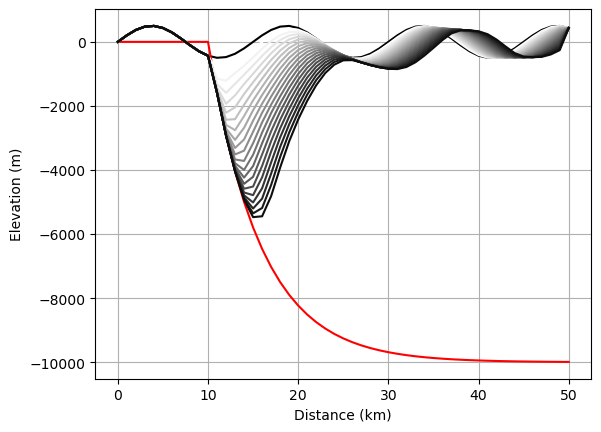

In [30]:
# Plot the starting elevations, in cross-section (middle row)
midrow = np.arange(ncols, 2 * ncols, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], "k")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.grid(True)

# Add a plot of the fault plane
dist_from_fault = grid.x_of_node - fault_x0
dist_from_fault[dist_from_fault < 0.0] = 0.0
x0 = detachment_depth / np.tan(np.deg2rad(fault_dip))
fault_plane = -(detachment_depth * (1.0 - np.exp(-dist_from_fault / x0)))
plt.plot(grid.x_of_node[midrow] / 1000.0, fault_plane[midrow], "r")

for i in range(nsteps):
    extender.run_one_step(dt)
    c = 1.0 - i / nsteps
    plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], color=[c, c, c])

### Example 3: extending to 2D

In [31]:
# parameters
nrows = 31
ncols = 51
dx = 1000.0  # grid spacing, m
nsteps = 20  # number of iterations
dt = 2.5e5  # time step, y
extension_rate = 0.001  # m/y
detachment_depth = 10000.0  # m
fault_dip = 60.0  # fault dip angle, degrees
fault_x0 = 10000.0  # m from left side of model
period = 15000.0  # period of sinusoidal variations in initial topography, m
ampl = 500.0  # amplitude of variations, m

In [32]:
# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = (
    ampl
    * np.sin(2 * np.pi * grid.x_of_node / period)
    * np.sin(2 * np.pi * grid.y_of_node / period)
)

# Instantiate component
extender = ListricKinematicExtender(
    grid,
    extension_rate_x=extension_rate,
    extension_rate_y=0.0,
    fault_dip=fault_dip,
    fault_strike=90.0,
    fault_x0=fault_x0,
    fault_y0=0.0,
    detachment_depth=detachment_depth,
)

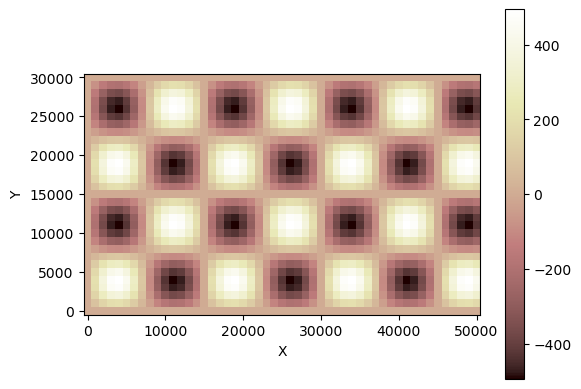

In [33]:
# Plot the starting topography
imshow_grid(grid, elev)

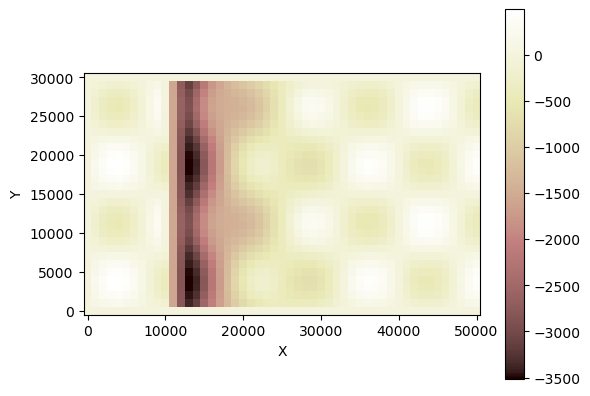

In [34]:
for i in range(nsteps // 2):
    extender.run_one_step(dt)
imshow_grid(grid, elev)

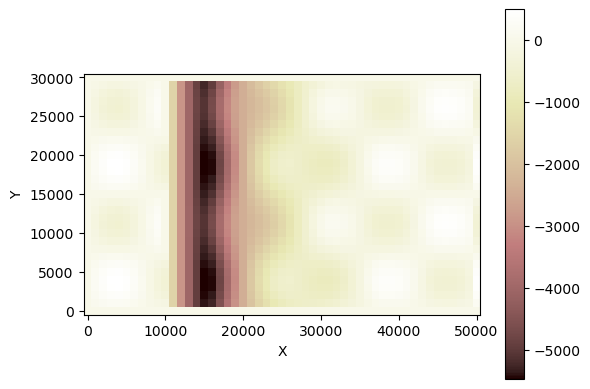

In [35]:
for i in range(nsteps // 2):
    extender.run_one_step(dt)
imshow_grid(grid, elev)

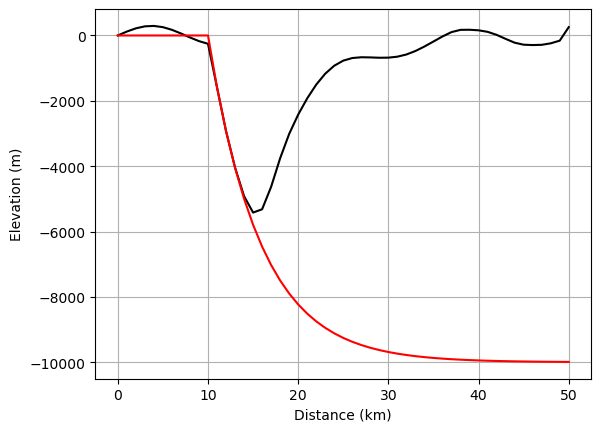

In [36]:
# Plot a cross-section
start_node = 6 * ncols
end_node = start_node + ncols
midrow = np.arange(start_node, end_node, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], "k")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.grid(True)

# Add a plot of the fault plane
dist_from_fault = grid.x_of_node - fault_x0
dist_from_fault[dist_from_fault < 0.0] = 0.0
x0 = detachment_depth / np.tan(np.deg2rad(fault_dip))
fault_plane = -(detachment_depth * (1.0 - np.exp(-dist_from_fault / x0)))
plt.plot(grid.x_of_node[midrow] / 1000.0, fault_plane[midrow], "r")

### Example 4: hex grid

In [37]:
from landlab import HexModelGrid

# parameters
nrows = 31
ncols = 51
dx = 1000.0  # grid spacing, m
nsteps = 20  # number of iterations
dt = 2.5e5  # time step, y
extension_rate = 0.001  # m/y
detachment_depth = 10000.0  # m
fault_dip = 60.0  # fault dip angle, degrees
fault_x0 = 10000.0  # m from left side of model
fault_strike = 60.0  # strike, degrees ccw from east
period = 15000.0  # period of sinusoidal variations in initial topography, m
ampl = 500.0  # amplitude of variations, m

In [38]:
# Create grid and elevation field
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = (
    ampl
    * np.sin(2 * np.pi * grid.x_of_node / period)
    * np.sin(2 * np.pi * grid.y_of_node / period)
)

# Instantiate component
extender = ListricKinematicExtender(
    grid,
    extension_rate_x=extension_rate,
    extension_rate_y=0.0,
    fault_dip=fault_dip,
    fault_strike=fault_strike,
    fault_x0=fault_x0,
    fault_y0=0.0,
    detachment_depth=detachment_depth,
)

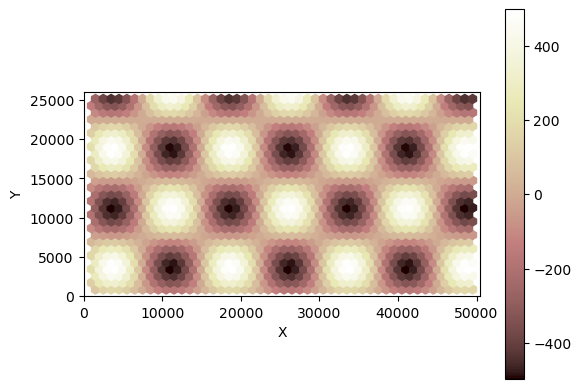

In [39]:
# Plot the starting topography
imshow_grid(grid, elev)

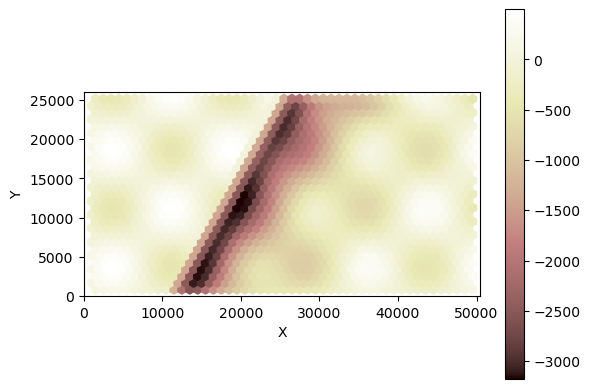

In [40]:
for i in range(nsteps // 2):
    extender.run_one_step(dt)
imshow_grid(grid, elev)

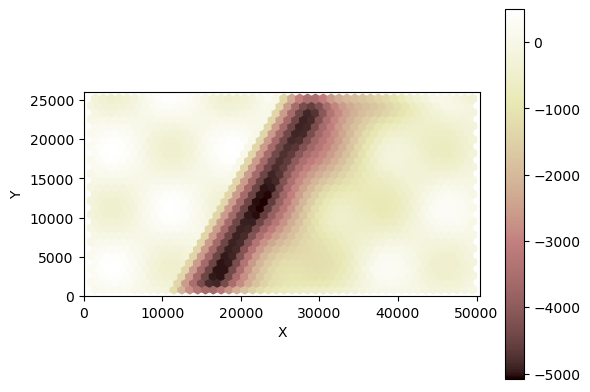

In [41]:
for i in range(nsteps // 2):
    extender.run_one_step(dt)
imshow_grid(grid, elev)

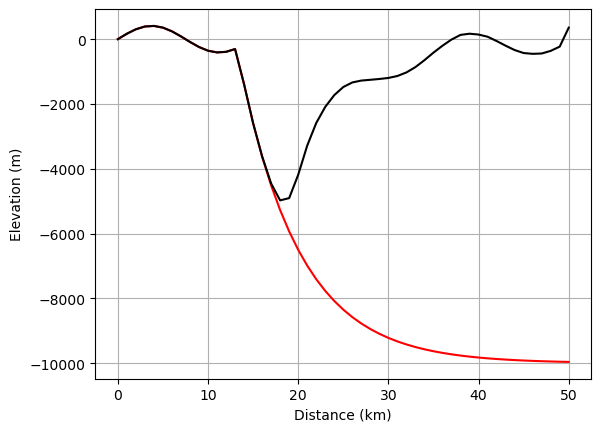

In [46]:
# Plot a cross-section
start_node = 6 * ncols
end_node = start_node + ncols
midrow = np.arange(start_node, end_node, dtype=int)
plt.plot(grid.x_of_node[midrow] / 1000.0, grid.at_node["fault_plane__elevation"][midrow], 'r')
plt.plot(grid.x_of_node[midrow] / 1000.0, elev[midrow], "k")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.grid(True)

### Example 5: Integrating with flexure

By itself, `ListricKinematicExtender` does not include rift-shoulder uplift, which in nature (at least in the author's understanding) occurs as a result of flexural isostatic uplift in response to extensional thinning of the crust, and also possibly as a result of thermal isostatic uplift in the underlying mantle. To handle the first of these, `ListricKinematicExtender` is designed to work together with a flexural isostasy component. The basic idea is to calculate explicitly the thinning of the crustal column that results from extension, so that this reduction in crustal thickness can be used by an isostasy component such as `Flexure`.

The basic concept behind `ListricKinematicExtender` is that thinning occurs when the hangingwall block is dragged away from the footwall, in effect sliding down the fault plane, as illustrated in the plot of topography and fault plane above. In order to combine with a flexural isostasy component, we need to keep track of the progressive reduction in crustal thickness. In the example below, we do this by keeping track of a quantity called "footwall thickness", which represents the thickness of material above an arbitrary datum fixed to the crustal column called "crust datum". The total thickness of material is then the sum of footwall and hangingwall thickness, and changes in this thickness create a positive or negative load. We use the `Flexure` component to calculate the net deflection (positive downward) resulting from this load. Because the initial condition itself will create a deflection, we record this initial deflection and then subtract it from subsequent deflection, to arrive at the net deflection resulting from crustal extension.

In [99]:
from landlab.components import Flexure

# parameters
nrows = 31
ncols = 51
dx = 1000.0  # grid spacing, m
nsteps = 20  # number of iterations
dt = 2.5e5  # time step, y
extension_rate = 0.001  # m/y
detachment_depth = 10000.0  # m
fault_dip = 60.0  # fault dip angle, degrees
fault_x0 = 10000.0  # m from left side of model
period = 15000.0  # period of sinusoidal variations in initial topography, m
ampl = 500.0  # amplitude of variations, m

# flexural parameters
eet = 5000.0  # effective elastic thickness, m (here very thin)
crust_datum = -10000.0  # elevation of crustal reference datum, m
rhoc = 2700.0  # crust density, kg/m3
g = 9.8  # guess what?

In [100]:
# Create grid and elevation field
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = (
    ampl
    * np.sin(2 * np.pi * grid.x_of_node / period)
    * np.sin(2 * np.pi * grid.y_of_node / period)
)
total_thickness = grid.add_zeros("upper_crust_thickness", at="node")
fw_thickness = grid.add_zeros("footwall__thickness", at="node")
load = grid.add_zeros("lithosphere__overlying_pressure_increment", at="node")

# Instantiate components
extender = ListricKinematicExtender(
    grid,
    extension_rate_x=extension_rate,
    extension_rate_y=0.0,
    fault_dip=fault_dip,
    fault_strike=90.0,
    fault_x0=fault_x0,
    fault_y0=0.0,
    detachment_depth=detachment_depth,
)

hw_thickness = grid.at_node["hangingwall__thickness"]
fw_thickness = grid.at_node["fault_plane__elevation"] - crust_datum

flexer = Flexure(grid, eet=eet, method="flexure")
deflection = grid.at_node["lithosphere_surface__elevation_increment"]

In [101]:
# set up thickness and flexure
unit_wt = rhoc * g
total_thickness[:] = elev - crust_datum
load[:] = unit_wt * total_thickness

flexer.update()
init_flex = deflection.copy()

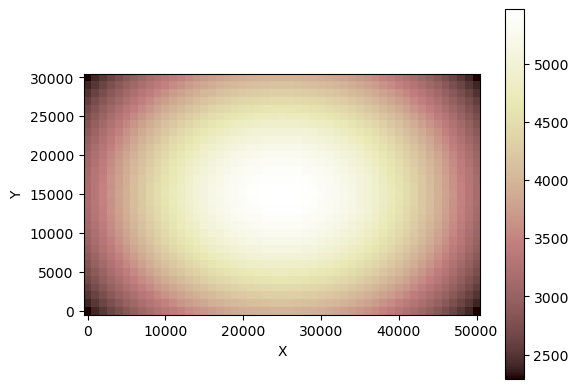

In [102]:
# show initial deflection field (positive downward)
imshow_grid(grid, init_flex)

In [103]:
for i in range(nsteps):
    extender.run_one_step(dt)
    total_thickness = fw_thickness + hw_thickness
    load[:] = unit_wt * total_thickness
    flexer.update()
    net_deflection = deflection - init_flex
    elev[:] = crust_datum + total_thickness - net_deflection

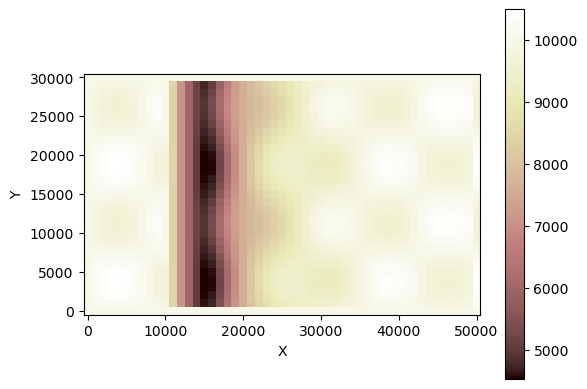

In [104]:
imshow_grid(grid, total_thickness)

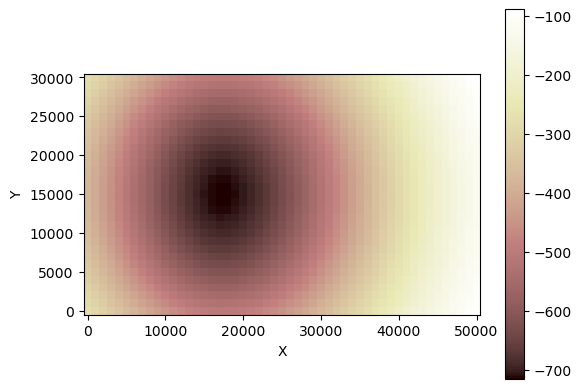

In [105]:
imshow_grid(grid, net_deflection)

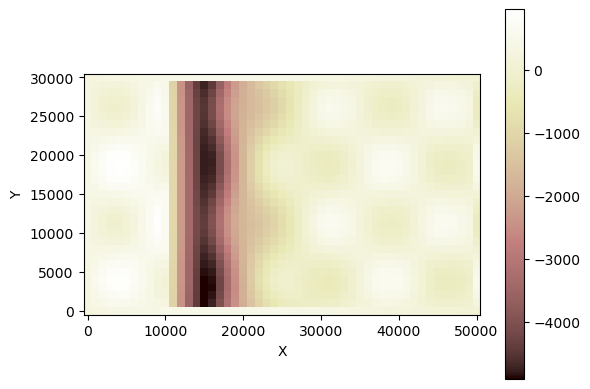

In [106]:
imshow_grid(grid, elev)

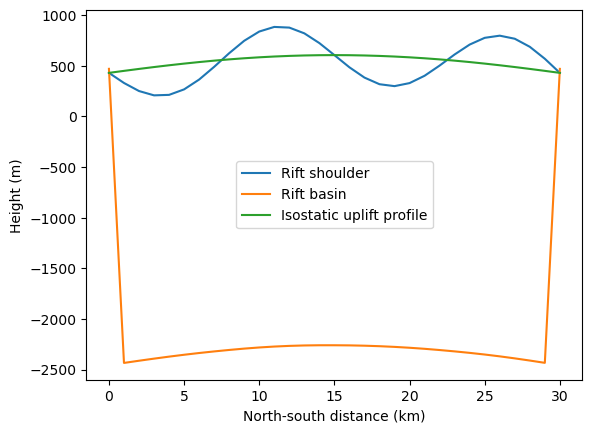

In [107]:
plt.plot(elev.reshape(31, 51)[:, 9], label="Rift shoulder")
plt.plot(elev.reshape(31, 51)[:, 12], label="Rift basin")
plt.plot(-net_deflection.reshape(31, 51)[:, 9], label="Isostatic uplift profile")
plt.xlabel("North-south distance (km)")
plt.ylabel("Height (m)")
plt.legend()

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>